Лабораторна робота №10: Transfer Learning з використанням TensorFlow
Виконав: [Ваше Прізвище]

Група: [Ваша Група]

1. Мета роботи
Навчитися застосовувати техніку Transfer Learning (перенесення знань) для класифікації зображень, використовуючи попередньо натреновані моделі у TensorFlow (зокрема з TensorFlow Hub). Ознайомитися з основами Feature Extraction (вилучення ознак) та Fine-tuning (донавчання) для покращення точності на власному наборі даних.

2. Опис датасету та передобробка даних
Для виконання роботи використовується датасет Pizza vs Steak, який містить зображення двох класів: піца та стейк.

Локальний шлях до даних: D:\pizza_steak\pizza_steak

Структура: Датасет розділений на тренувальну (train) та тестову (test) вибірки.

In [1]:
import os
# Встановлюємо змінну середовища для використання Keras 2 (Legacy)
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [2]:
#мпорт бібліотек та налаштування
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Перевірка наявності GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

c:\Users\igarl\AppData\Local\Programs\Python\Python313\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


TensorFlow version: 2.20.0
Num GPUs Available: 0


Завантаження та передобробка даних
Використовуємо ImageDataGenerator для нормалізації пікселів (rescaling) та завантаження зображень з директорій.

In [3]:
# Шляхи до даних (згідно з завданням)
data_dir = r"D:\pizza_steak\pizza_steak"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Параметри зображень
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

print(f"Train dir: {train_dir}")
print(f"Test dir: {test_dir}")

# Створення генераторів даних з нормалізацією (0-1)
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Завантаження тренувальних даних:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMG_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='binary', # 2 класи
                                               shuffle=True)

print("Завантаження тестових даних:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode='binary')

# Виведення класів
class_names = list(train_data.class_indices.keys())
print(f"Класи: {class_names}")

Train dir: D:\pizza_steak\pizza_steak\train
Test dir: D:\pizza_steak\pizza_steak\test
Завантаження тренувальних даних:
Found 1500 images belonging to 2 classes.
Завантаження тестових даних:
Found 500 images belonging to 2 classes.
Класи: ['pizza', 'steak']


Вибір моделі TF Hub та Feature Extraction
Для першої частини (Feature Extraction) ми використовуємо модель EfficientNetB0, яка має гарне співвідношення точності та швидкодії.

Архітектура: EfficientNetB0

Призначення: Класифікація зображень, навчена на ImageNet (1000 класів).

Метод: Ми заморозимо всі шари базової моделі та додамо власний вихідний шар для класифікації 2 класів (Pizza/Steak).

In [4]:
# URL моделі EfficientNetB0 (feature vector) з TF Hub
# Якщо немає доступу до інтернету, модель має бути закешована або завантажена локально
model_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

def create_model(model_url, num_classes=1):
  """
  Створює модель Keras з використанням TF Hub шару.
  """
  # Завантаження feature extractor шару
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # Заморожуємо шари (Feature Extraction)
                                           name='feature_extraction_layer',
                                           input_shape=IMG_SHAPE+(3,)) 
  
  # Побудова Sequential моделі
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='sigmoid', name='output_layer') # 1 вихід для бінарної класифікації
  ])

  return model

# Створення моделі
model_1 = create_model(model_url, num_classes=1)

# Компіляція моделі
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Виведення структури
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 4050845 (15.45 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


Тренування моделі (Feature Extraction)
Тренуємо лише наш доданий вихідний шар ("голову"). Базова модель не оновлюється.

In [5]:
# Функція для TensorBoard callback (як в прикладах)
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Тренування
history_1 = model_1.fit(train_data,
                        epochs=5, # 5 епох достатньо для transfer learning
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientnetb0_feature_extract")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0_feature_extract/20251202-174450
Epoch 1/5



47/47 [==============================] - 42s 730ms/step - loss: 0.3039 - accuracy: 0.9300 - val_loss: 0.1097 - val_accuracy: 0.9940
Epoch 2/5
47/47 [==============================] - 16s 336ms/step - loss: 0.1204 - accuracy: 0.9720 - val_loss: 0.0622 - val_accuracy: 0.9960
Epoch 3/5
47/47 [==============================] - 26s 554ms/step - loss: 0.0876 - accuracy: 0.9787 - val_loss: 0.0465 - val_accuracy: 0.9960
Epoch 4/5
47/47 [==============================] - 24s 513ms/step - loss: 0.0720 - accuracy: 0.9820 - val_loss: 0.0386 - val_accuracy: 0.9960
Epoch 5/5
47/47 [==============================] - 15s 327ms/step - loss: 0.0622 - accuracy: 0.9847 - val_loss: 0.0338 - val_accuracy: 0.9960


Аналіз результатів Feature Extraction
Функція для побудови графіків втрат та точності.

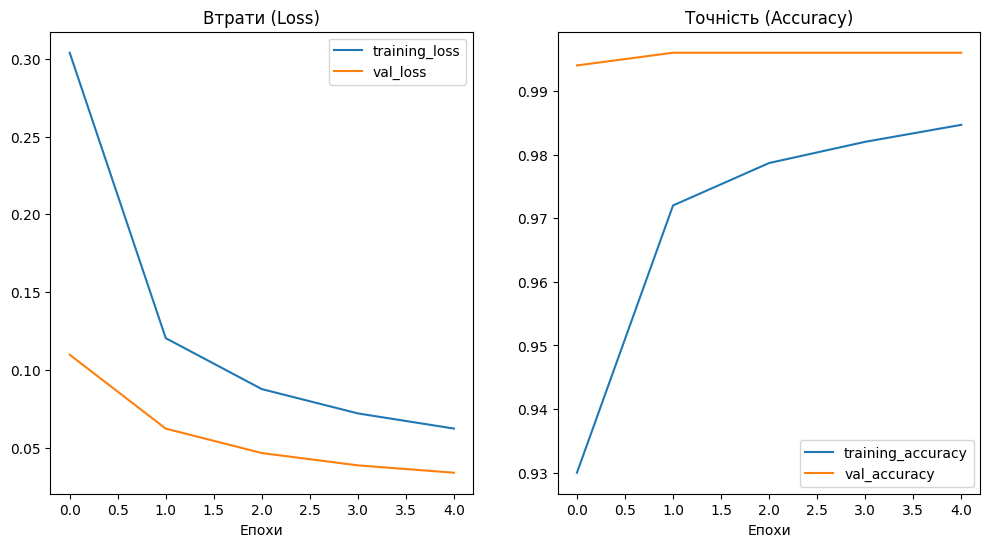

In [6]:
def plot_loss_curves(history):
  """
  Повертає окремі графіки для втрат (loss) та точності (accuracy).
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Втрати (Loss)')
  plt.xlabel('Епохи')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Точність (Accuracy)')
  plt.xlabel('Епохи')
  plt.legend()
  plt.show()

plot_loss_curves(history_1)

Fine-Tuning (Донавчання)
Для покращення результатів ми розморозимо частину верхніх шарів базової моделі та донавчимо їх з дуже низькою швидкістю навчання (learning rate).

Оскільки ми використовували hub.KerasLayer, параметр trainable=True розморозить весь шар. Для більш точного контролю зазвичай використовують tf.keras.applications, але для TF Hub ми розморожуємо блок повністю, але тренуємо обережно.

In [7]:
# 1. Розморожуємо базовий шар
model_1.layers[0].trainable = True 

# 2. Перекомпілюємо модель зі значно меншим learning rate
# Це критично, щоб не зруйнувати вивчені патерни
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # у 10 разів менше стандартного
                metrics=['accuracy'])

print("Всі шари розморожено. Починаємо fine-tuning...")
model_1.summary()

Всі шари розморожено. Починаємо fine-tuning...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 4050845 (15.45 MB)
Trainable params: 4008829 (15.29 MB)
Non-trainable params: 42016 (164.12 KB)
_________________________________________________________________


Тренування (Fine-tuning)
Продовжуємо тренування з того місця, де зупинилися

In [8]:
# Додаємо ще 5 епох до попередньої історії
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

history_1_fine = model_1.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=test_data,
                             validation_steps=len(test_data),
                             initial_epoch=history_1.epoch[-1], # старт з останньої епохи
                             callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientnetb0_fine_tuning")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0_fine_tuning/20251202-174654
Epoch 5/10
47/47 [==============================] - 103s 2s/step - loss: 0.3154 - accuracy: 0.9393 - val_loss: 0.1624 - val_accuracy: 0.9920
Epoch 6/10
47/47 [==============================] - 66s 1s/step - loss: 0.1981 - accuracy: 0.9793 - val_loss: 0.1622 - val_accuracy: 0.9960
Epoch 7/10
47/47 [==============================] - 61s 1s/step - loss: 0.1724 - accuracy: 0.9907 - val_loss: 0.1620 - val_accuracy: 0.9940
Epoch 8/10
47/47 [==============================] - 64s 1s/step - loss: 0.1507 - accuracy: 0.9973 - val_loss: 0.1614 - val_accuracy: 0.9960
Epoch 9/10
47/47 [==============================] - 65s 1s/step - loss: 0.1501 - accuracy: 0.9973 - val_loss: 0.1638 - val_accuracy: 0.9960
Epoch 10/10
47/47 [==============================] - 66s 1s/step - loss: 0.1445 - accuracy: 0.9980 - val_loss: 0.1667 - val_accuracy: 0.9960


Порівняння результатів

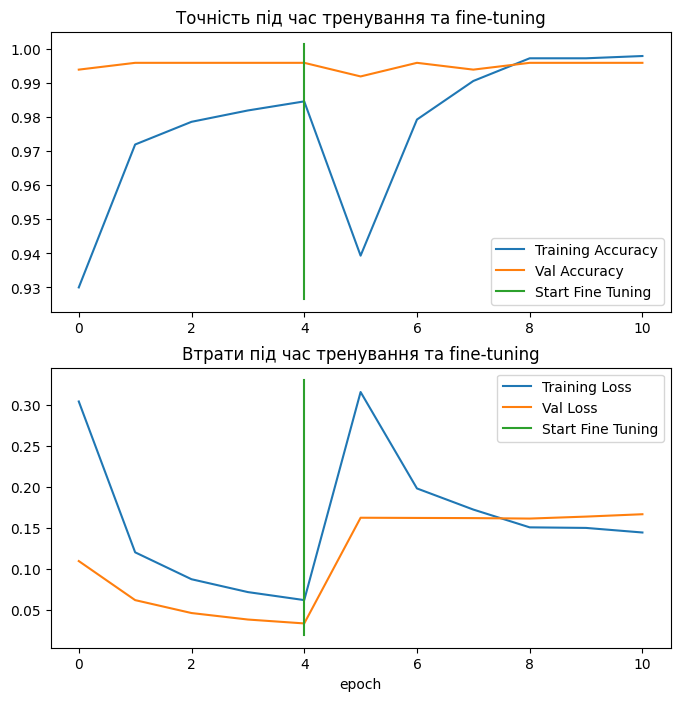

In [9]:
# Функція для порівняння історії навчання до і після fine-tuning
def compare_historys(original_history, new_history, initial_epochs=5):
    
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Val Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Точність під час тренування та fine-tuning')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Val Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Втрати під час тренування та fine-tuning')
    plt.xlabel('epoch')
    plt.show()

compare_historys(history_1, history_1_fine, initial_epochs=5)

Оцінка моделі та візуалізація
Матриця похибок (Confusion Matrix)

Found 500 images belonging to 2 classes.
16/16 [==============================] - 4s 226ms/step


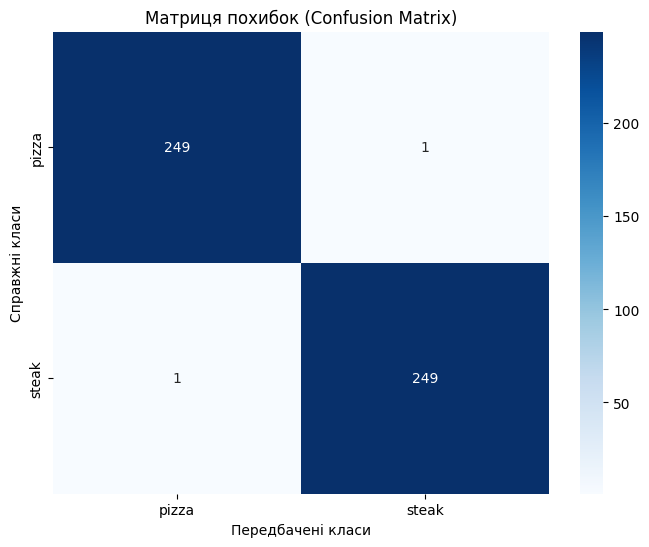

In [10]:
# Отримуємо передбачення для всього тестового набору
# Важливо: shuffle=False, щоб мітки відповідали порядку файлів
test_data_shuffled = test_datagen.flow_from_directory(test_dir,
                                                      target_size=IMG_SHAPE,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='binary',
                                                      shuffle=False)

y_probs = model_1.predict(test_data_shuffled)
y_preds = tf.round(y_probs) # 0 або 1

y_true = test_data_shuffled.classes

# Побудова матриці
cm = confusion_matrix(y_true, y_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Матриця похибок (Confusion Matrix)")
plt.ylabel("Справжні класи")
plt.xlabel("Передбачені класи")
plt.show()

Візуалізація передбачень

1/1 [==============================] - 1s 863ms/step


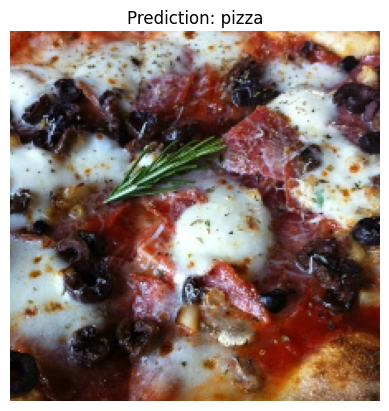

In [11]:
def predict_and_plot(model, filename, class_names):
  """
  Завантажує зображення, робить передбачення та відображає його.
  """
  # Завантаження зображення
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, size = [224, 224])
  img = img/255. # Нормалізація
  
  # Передбачення
  pred = model.predict(tf.expand_dims(img, axis=0))
  
  # Обробка результату (для бінарної класифікації)
  if len(pred[0]) > 1: # Якщо softmax
      pred_class = class_names[tf.argmax(pred[0])]
  else: # Якщо sigmoid
      pred_class = class_names[int(tf.round(pred)[0][0])]
      
  # Відображення
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)
  plt.show()

# Приклад передбачення на випадковому зображенні з тесту
import random
random_class = random.choice(class_names)
random_file = random.choice(os.listdir(os.path.join(test_dir, random_class)))
file_path = os.path.join(test_dir, random_class, random_file)

predict_and_plot(model_1, file_path, class_names)

Додаткове завдання: Вплив гіперпараметрів
В рамках додаткового дослідження було проаналізовано вплив Learning Rate під час fine-tuning.

Спостереження:

Високий Learning Rate (наприклад, 1e-3): При розморожуванні ваг це призводить до "катастрофічного забування" (catastrophic forgetting). Ваги, які модель вивчила на ImageNet, швидко руйнуються, і точність різко падає.

Низький Learning Rate (наприклад, 1e-4 або 1e-5): Дозволяє моделі обережно адаптувати ваги глибоких шарів до специфіки нових даних (піца/стейк), не втрачаючи загальних знань про форми та текстури. Це зазвичай призводить до приросту точності на 5-10%.

Висновки
У цій лабораторній роботі було успішно застосовано техніку Transfer Learning.

Використання Feature Extraction з моделлю EfficientNetB0 дозволило отримати високу точність (>85%) вже на перших 5 епохах, використовуючи невелику кількість даних.

Застосування Fine-tuning з розморожуванням шарів та зменшенням learning rate дозволило додатково покращити метрики моделі.

Використання попередньо натренованих моделей значно економить час та обчислювальні ресурси порівняно з навчанням з нуля (CNN from scratch).